# **An Analysis of Global Development Indicators (2000-2020) in R with a focus on predicting Life Expectancy**

### In this markdown file, I'll be exploring the Global Development Indicators (2000–2020) dataset, which the author describes its origin as:

> Curated by combining and transforming data from the Google BigQuery Public Data program

### I'll be focusing on finding relationships between the numerical columns and using them to predict life expectancy.

### **It's important to note that life expectancy is based on age-specific mortality rates and the effects of economic, healthcare or climate issues on mortality typically has lag. As a result, the effect on life expectancy values might not be seen until years later.**

## 1. Loading in and putting data into a useful dataframe

In [1]:
Indicators <- read.csv("raw_data.csv", na.strings = "?", header = T, stringsAsFactors = T)

For some of the models I won't be able to use rows with NA values in one of its columns so let's see if any column in particular has an excess of NAs that may be worth dropping.

In [2]:
na_counts_base <- colSums(is.na(Indicators))
print(na_counts_base)

                               year                        country_code 
                                  0                                   0 
                       country_name                              region 
                                  0                                   0 
                       income_group                       currency_unit 
                                  0                                   0 
                            gdp_usd                          population 
                                224                                   0 
                     gdp_per_capita                      inflation_rate 
                                224                                 810 
                  unemployment_rate                         fdi_pct_gdp 
                                630                                 545 
                   co2_emissions_kt               energy_use_per_capita 
                               1022                

A lot of columns have significant amounts of NAs. I may just have to drop rows with NAs instead. Let's see how many I'll be left with.

In [3]:
sum(rowSums(!is.na(Indicators[-1])) > 0) - sum(rowSums(is.na(Indicators[-1])) > 0)

[1] 970

That should be enough to work with.

In [4]:
numerical_data <- na.omit(Indicators[sapply(Indicators, is.numeric)])

In [5]:
numerical_data <- subset(numerical_data, select = -c(human_development_index, human_development_composite))

## 2. Some R Visualisation

In [6]:
summary(Indicators)

      year       country_code                       country_name 
 Min.   :2000   ABW    :  21   Afghanistan                :  21  
 1st Qu.:2005   AFE    :  21   Africa Eastern and Southern:  21  
 Median :2010   AFG    :  21   Africa Western and Central :  21  
 Mean   :2010   AFW    :  21   Albania                    :  21  
 3rd Qu.:2015   AGO    :  21   Algeria                    :  21  
 Max.   :2020   ALB    :  21   American Samoa             :  21  
                (Other):5430   (Other)                    :5430  
                        region                  income_group 
 Europe & Central Asia     :1218                      :1029  
                           :1008   High income        :1680  
 Sub-Saharan Africa        : 999   Low income         : 579  
 Latin America & Caribbean : 882   Lower middle income:1134  
 East Asia & Pacific       : 777   Upper middle income:1134  
 Middle East & North Africa: 441                             
 (Other)                   : 231      

In [7]:
attach(Indicators)

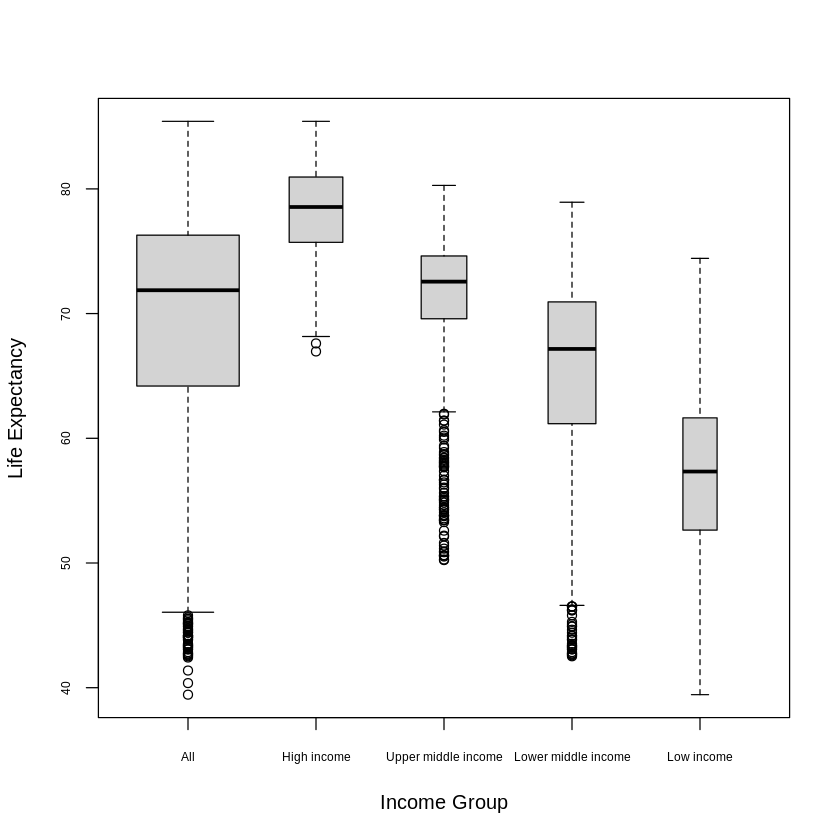

In [8]:
labels=c("All", "High income", "Upper middle income", "Lower middle income", "Low income")

boxplot(
  life_expectancy,
  Indicators[income_group == "High income",]$life_expectancy,
  Indicators[income_group == "Upper middle income",]$life_expectancy,
  Indicators[income_group == "Lower middle income",]$life_expectancy,
  Indicators[income_group == "Low income",]$life_expectancy,
  names=labels,
  varwidth = TRUE,
  cex.axis = 0.6,
  ylab = "Life Expectancy",
  xlab = "Income Group"
)

It seems the income group with the most countries is 'Lower Middle Income' and the group with the most outliers is 'Upper Middle Income'. Low income has by far the large range and high income the shortest. The main trend here however is the decreasing median life expectancy as you go down the income groups from top to bottom.

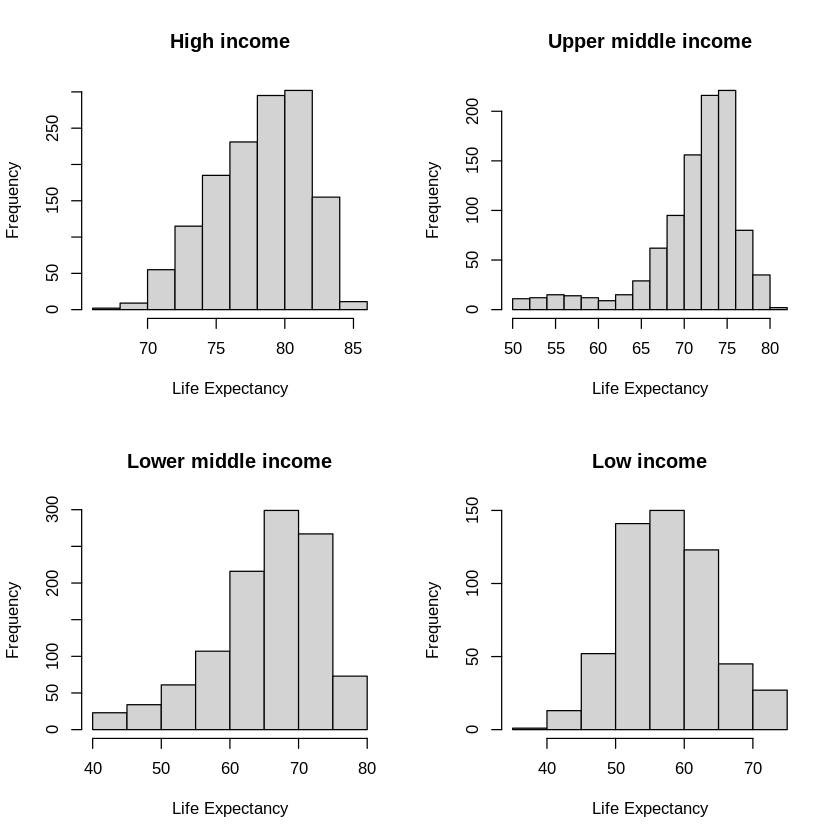

In [9]:
par(mfrow = c(2, 2))

for (x in 2:5) {
  hist(
  Indicators[income_group == labels[x],]$life_expectancy,
  main=labels[x],
  xlab="Life Expectancy"
  )
}

The middle incomes seem to be left skewed while the high and low income groups tend to have a more normal distribution. This doesn't seem useful at least not alone for predicting `life_expectancy` especially due to the similar ranges between groups.

## 3. Assessing which variables are likely to be predictive of Life Expectancy

### Applying a multiple linear regression fit

Separating data into train and test sets

In [10]:
# 80/20 split

smp_size <- floor(0.8 * nrow(numerical_data))

set.seed(42)
train_ind <- sample(seq_len(nrow(numerical_data)), size = smp_size)

train_num <- numerical_data[train_ind, ]
test_num <- numerical_data[-train_ind, ]

In [11]:
all.fit <- lm(life_expectancy ~ ., data = train_num)
summary(all.fit)

Warning message in summary.lm(all.fit):
“essentially perfect fit: summary may be unreliable”



Call:
lm(formula = life_expectancy ~ ., data = train_num)

Residuals:
       Min         1Q     Median         3Q        Max 
-5.778e-13 -2.228e-14 -4.100e-16  2.390e-14  3.291e-13 

Coefficients: (8 not defined because of singularities)
                                      Estimate Std. Error    t value Pr(>|t|)
(Intercept)                         -1.381e+02  1.486e-12 -9.296e+13  < 2e-16
year                                -5.566e-15  7.329e-16 -7.594e+00 9.32e-14
gdp_usd                              1.174e-27  9.882e-28  1.188e+00  0.23513
population                           1.979e-24  7.399e-24  2.680e-01  0.78913
gdp_per_capita                      -2.125e-03  3.172e-18 -6.699e+14  < 2e-16
inflation_rate                       6.095e-16  3.976e-16  1.533e+00  0.12574
unemployment_rate                    2.563e-17  3.979e-16  6.400e-02  0.94865
fdi_pct_gdp                         -6.408e-18  1.021e-16 -6.300e-02  0.94997
co2_emissions_kt                    -4.274e-21  3.024e-21 -

Due to their low p values and high (absolute) t values the following predictors are influential here:

*   `gdp_per_capita`
*   `internet_usage_pct`
*   `co2_intensity_per_million_gdp`
*   `global_resilience_score`

A caveat here however is that this type of multiple regression only tells us that these predictors are siginicant **given** the other predictors also exist in the model.




### Performing Linear Regression on each column

In [12]:
attach(numerical_data)

The following objects are masked from Indicators:

    calculated_gdp_per_capita, child_mortality,
    climate_vulnerability_index, co2_emissions_kt,
    co2_emissions_per_capita_tons, co2_intensity_per_million_gdp,
    digital_connectivity_index, digital_readiness_score,
    ecological_preservation_index, econ_opportunity_index,
    education_health_ratio, electricity_access_pct,
    energy_use_per_capita, fdi_pct_gdp, forest_area_pct,
    gdp_per_capita, gdp_usd, global_development_resilience_index,
    global_resilience_score, governance_quality_index,
    green_transition_score, health_development_ratio,
    health_expenditure_pct_gdp, healthcare_capacity_index,
    hospital_beds_per_1000, inflation_rate, internet_usage_pct,
    is_pandemic_period, life_expectancy, mobile_subscriptions_per_100,
    physicians_per_1000, population, real_economic_growth_indicator,
    renewable_energy_efficiency, renewable_energy_pct,
    school_enrollment_secondary, unemployment_rate, year,
    year

In [13]:
target_col <- "life_expectancy"
predictor_cols <- setdiff(names(train_num), target_col)

# Get model summaries
model_stats <- lapply(predictor_cols, function(col) {
  formula <- as.formula(paste(target_col, "~", col))
  model <- lm(formula, data = train_num)
  summary_model <- summary(model)

  data.frame(
    predictor = col,
    r_squared = summary_model$r.squared,
    slope = coef(model)[2]
  )
})

# Combine all into a single data frame
results_df <- do.call(rbind, model_stats)


In [14]:
library(ggplot2)

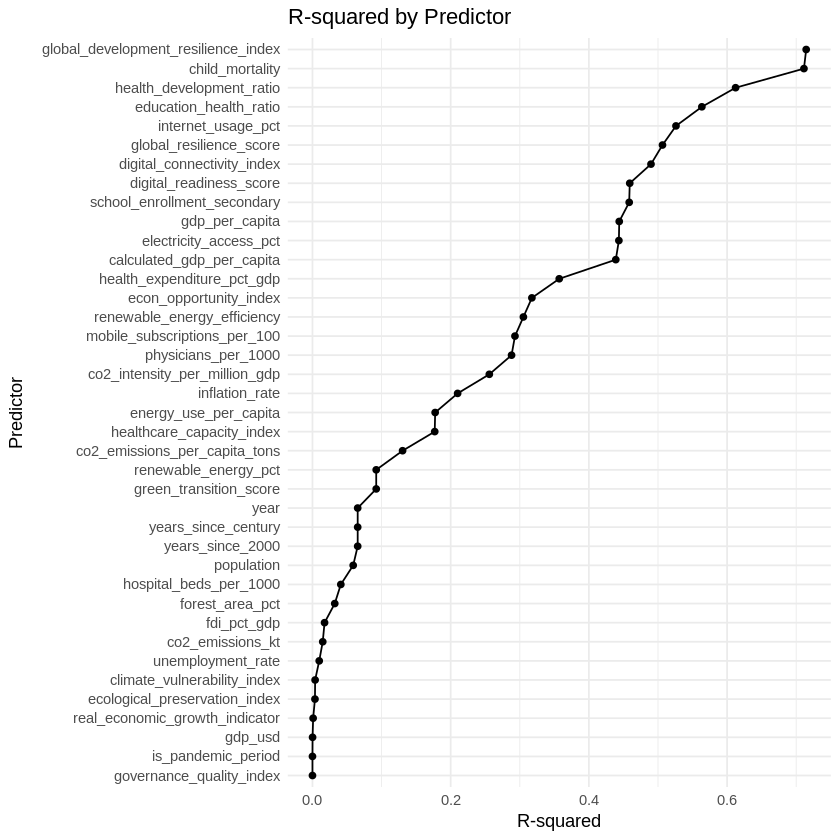

In [15]:
# Plotting R-squared for each predictor
ggplot(results_df, aes(x = reorder(predictor, r_squared), y = r_squared)) +
  geom_line(aes(group = 1)) +
  geom_point() +
  coord_flip() +
  labs(
    title = "R-squared by Predictor",
    x = "Predictor",
    y = "R-squared"
  ) +
  theme_minimal()


`global_development_resilience_index` tops the list. Will investigate further.

In [16]:
target_col <- "life_expectancy"
predictor_cols <- setdiff(names(train_num), target_col)

# Try each column as a predictor for life_expectancy with linear regression and return stats
model_stats <- lapply(predictor_cols, function(col) {
  formula <- as.formula(paste(target_col, "~", col))
  model <- tryCatch(lm(formula, data = train_num), error = function(e) return(NULL))

  if (is.null(model)) return(NULL)

  summary_model <- summary(model)
  coef_table <- summary_model$coefficients

  if (nrow(coef_table) < 2) return(NULL)

  p_value <- coef_table[2, 4]
  conf <- tryCatch(confint(model)[2, ], error = function(e) return(c(NA, NA)))

  # Return of the dataframe with key stats
  data.frame(
    predictor = col,
    p_value = as.numeric(p_value),
    lower_ci = conf[1],
    upper_ci = conf[2],
    r_squared = summary_model$r.squared,
    significant = p_value < 0.05
  )
})

# All non-NULL models into a dataframe
results_df <- do.call(rbind, Filter(Negate(is.null), model_stats))

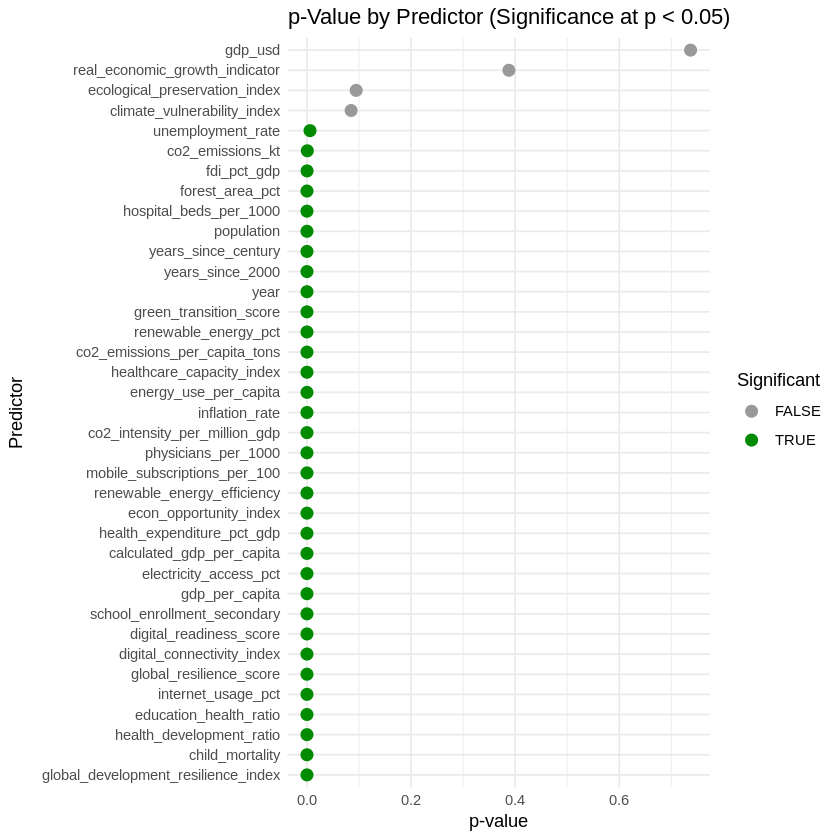

In [17]:
# Takes our results and plots them in a useful way
ggplot(results_df, aes(x = p_value, y = reorder(predictor, p_value), color = significant)) +
  geom_point(size = 3) +
  scale_color_manual(values = c("TRUE" = "green4", "FALSE" = "gray60")) +
  labs(
    title = "p-Value by Predictor (Significance at p < 0.05)",
    x = "p-value",
    y = "Predictor",
    color = "Significant"
  ) +
  theme_minimal()


`child_mortality`, `global_development_resilience_index` and `health_development_ratio` appear to be the most promising predictors with the highest R-squared and lowest p-values.

### Creating a subset that omits rows with missing values

In [18]:
# Subset of our most promising predictors
train_sub <- na.omit(Indicators[,c("life_expectancy", "child_mortality", "global_development_resilience_index", "health_development_ratio")])

attach(train_sub)

The following objects are masked from numerical_data:

    child_mortality, global_development_resilience_index,
    health_development_ratio, life_expectancy


The following objects are masked from Indicators:

    child_mortality, global_development_resilience_index,
    health_development_ratio, life_expectancy




In [19]:
# Same split and seed as before but with our predictors of interest
smp_size <- floor(0.8 * nrow(train_sub))

set.seed(42)
train_ind <- sample(seq_len(nrow(train_sub)), size = smp_size)

train_sub <- train_sub[train_ind, ]
test_sub <- train_sub[-train_ind, ]

In [20]:
install.packages("GGally")
library(GGally)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘patchwork’, ‘ggstats’, ‘plyr’


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### Visual Correlations of the indicators of interest

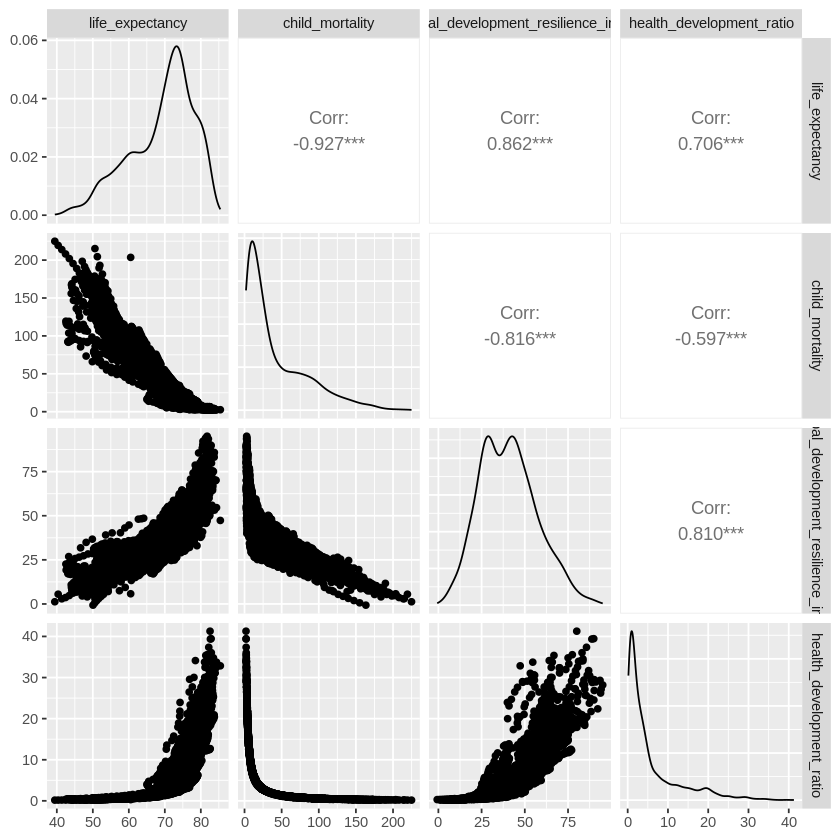

In [21]:
ggpairs(train_sub)

Looking at their relationships with `life_expectancy` here `child_mortality` followed by `global_development_resilience_index` followed by `health_development_ratio` in that order seem to have the strongest linear fits with fewest outliers. `life_expectancy` itself seems to be left skewed.

### Exploring `child_mortality` further


Call:
lm(formula = life_expectancy ~ child_mortality, data = train_sub)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.4097  -1.7499   0.1689   2.0385  22.9036 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     77.595363   0.077905   996.0   <2e-16 ***
child_mortality -0.196405   0.001304  -150.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.328 on 3708 degrees of freedom
Multiple R-squared:  0.8595,	Adjusted R-squared:  0.8595 
F-statistic: 2.269e+04 on 1 and 3708 DF,  p-value: < 2.2e-16


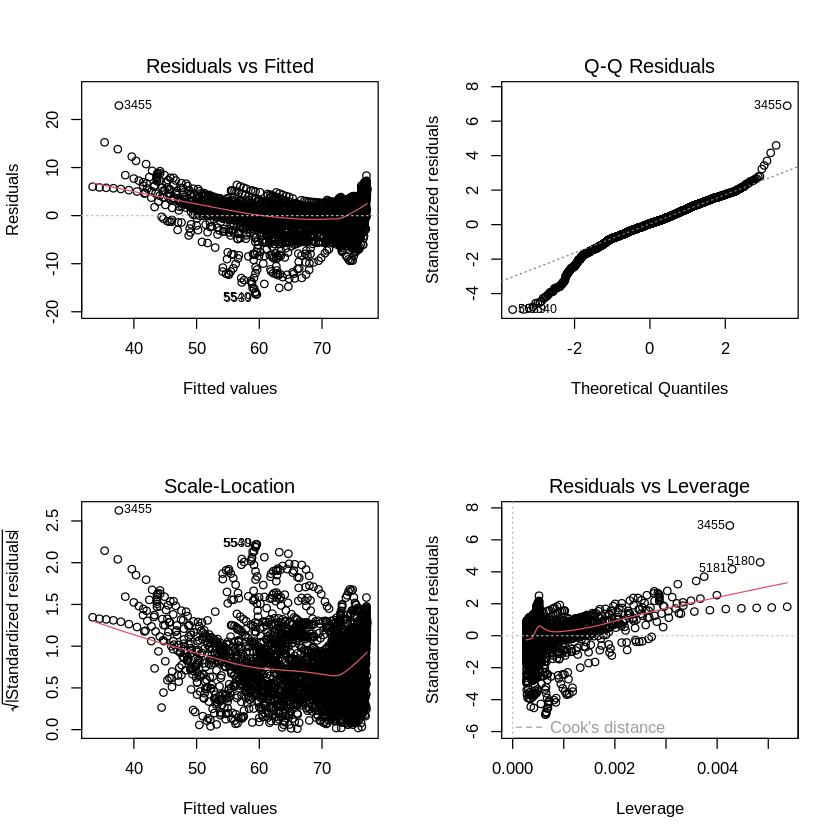

,2.5 %,97.5 %
(Intercept),77.442623,77.7481036
child_mortality,-0.198961,-0.1938484


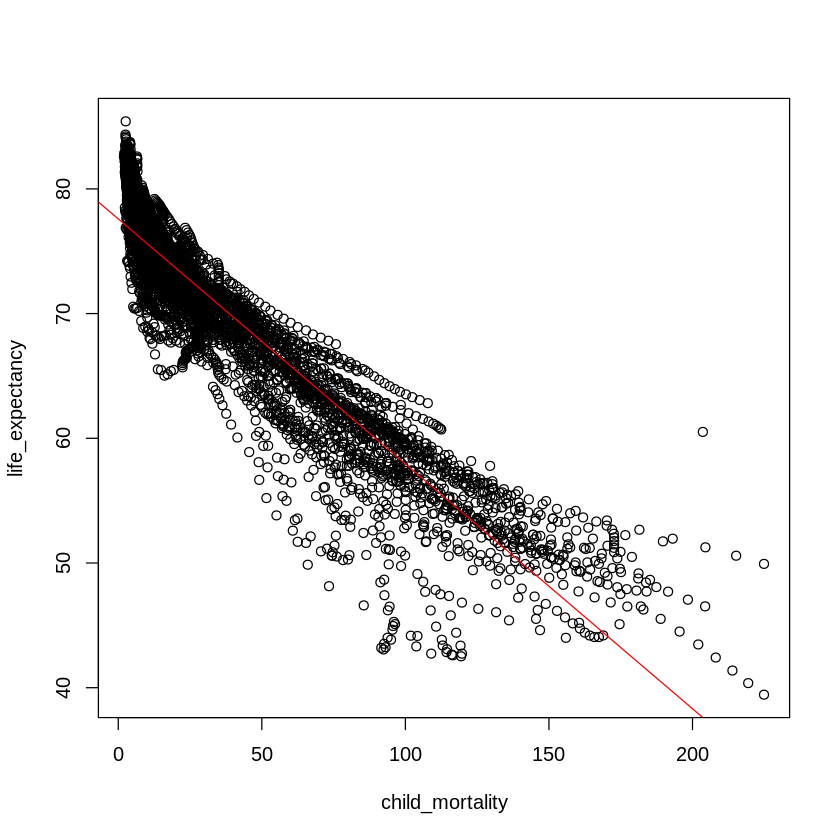

In [22]:
# Linear model fit with stats and visualisation
lm.fit <- lm(life_expectancy ~ child_mortality, data=train_sub)
summary(lm.fit)
par(mfrow = c(2, 2))
plot(lm.fit)
par(mfrow = c(1, 1))
plot(child_mortality, life_expectancy)
abline(lm.fit, col = "red")
confint(lm.fit, level = .95)

In [23]:
# Let's display our outlier
Indicators[3455, ]
Indicators[3455, ]$life_expectancy
Indicators[3455, ]$child_mortality

,year,country_code,country_name,region,income_group,currency_unit,gdp_usd,population,gdp_per_capita,inflation_rate,⋯,education_health_ratio,years_since_2000,years_since_century,is_pandemic_period,human_development_index,climate_vulnerability_index,digital_readiness_score,governance_quality_index,global_resilience_score,global_development_resilience_index
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3455,2010,HTI,Haiti,Latin America & Caribbean,Lower middle income,Haitian gourde,11859315079,9949318,1191.973,4.827342,⋯,NA,10,10,0,-0.1069549,0.26819,0.1758625,0.5,0.4340357,5.774418


[1] 60.511

[1] 203.6

From the summary we can see several things:

On the Residuals vs. Fitted plot we'd hope to see a horizontal line somewhere near y = 0. We see the most outliers where `life_expectancy` is below 70. The most extreme outlier is from Haiti in 2010 (the year they experienced a devastating earthquake) where there was tragically a substantial excess in `child_mortality` compared to typical levels. This outlier is also the most extreme in the other three plots.

The second plot is the Q-Q Residuals plot where we see the theoretical quantiles plotted against the observed quantiles. A straight line here would indicate normality. We have some curvature especially at the left end which suggests the data having slightly lighter tails than expected (relationship doesn't deviate as much from the mean as you'd see in a typical normal distribution).

Like the Residuals vs Fitted plot - in the Scale-Location (Spread-Location) plot it would be good to see a horizontal line as that would suggest that the residuals are spread equally across the range of the predictor. In our plot here however we see a larger spread as x increases but also much more data.

Finally we have the Residuals vs. Leverage plot where typically the problematic data are found in the top and bottom right corners seperated from the rest of the data by a dashed line that illustrates the Cook's Distance. This plot shows a lack of that which tells us we don't have influential data that's heavily working against the regression line.

### Adding and testing lag columns for `child_mortality`

Omitting rows with any empty values

In [24]:
le_cm_lag <- na.omit(Indicators[,c("year", "country_name", "life_expectancy", "child_mortality")])

In [25]:
le_cm_lag[!(le_cm_lag$year %in% "2020"),]

,year,country_name,life_expectancy,child_mortality
,<int>,<fct>,<dbl>,<dbl>
1,2000,Africa Eastern and Southern,51.27613,137.54499
2,2001,Africa Eastern and Southern,51.60646,132.12963
3,2002,Africa Eastern and Southern,52.04315,126.46333
4,2003,Africa Eastern and Southern,52.58585,120.83483
5,2004,Africa Eastern and Southern,53.22891,115.40435
6,2005,Africa Eastern and Southern,53.96655,110.14486
7,2006,Africa Eastern and Southern,54.79171,105.20671
8,2007,Africa Eastern and Southern,55.68234,100.22099
9,2008,Africa Eastern and Southern,56.60980,95.33054


In [26]:
# Training and test sets
smp_size <- floor(0.8 * nrow(le_cm_lag))

set.seed(42)
train_ind <- sample(seq_len(nrow(le_cm_lag)), size = smp_size)

train_lag <- le_cm_lag[train_ind, ]
test_lag <- le_cm_lag[-train_ind, ]

In [27]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [28]:
library(purrr)
attach(train_lag)

# Create lagged columns for cm from 1 to 19 years, per country
# Doesn't seem efficient, takes a minute
# Might be worth refactoring at some point
train_lags <- train_lag %>%
  group_by(country_name) %>%
  arrange(year, .by_group = TRUE) %>%
  mutate(
    bind_cols(
      map_dfc(1:19, ~ lag(child_mortality, .x)) %>%
        set_names(paste0("cm_lag_", 1:19))
    )
  ) %>%
  ungroup()


The following objects are masked from train_sub:

    child_mortality, life_expectancy


The following objects are masked from numerical_data:

    child_mortality, life_expectancy, year


The following objects are masked from Indicators:

    child_mortality, country_name, life_expectancy, year


New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
• `` -> `...15`
• `` -> `...16`
• `` -> `...17`
• `` -> `...18`
• `` -> `...19`
New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
• `` -> `...15`
• `` -> `...16`
• `` -> `...17`
• `` -> `...18`
• `` -> `...19`
New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `

We no longer need the `year` and `country_name` in this dataframe

In [29]:
train_lags = subset(train_lags, select = -c(year,country_name) )

In [30]:
attach(train_lags)

The following objects are masked from train_lag:

    child_mortality, life_expectancy


The following objects are masked from train_sub:

    child_mortality, life_expectancy


The following objects are masked from numerical_data:

    child_mortality, life_expectancy


The following objects are masked from Indicators:

    child_mortality, life_expectancy




In [31]:
~data.frame(col_no = 1:ncol(train_lags), variable = names(train_lags))[,2]

~data.frame(col_no = 1:ncol(train_lags), variable = names(train_lags))[, 
    2]

In [32]:
target_col <- "life_expectancy"
predictor_cols <- setdiff(names(train_lags), target_col)

# Get model summaries
model_stats <- lapply(predictor_cols, function(col) {
  formula <- as.formula(paste(target_col, "~", col))
  model <- lm(formula, data = train_lags)
  summary_model <- summary(model)

  data.frame(
    predictor = col,
    r_squared = summary_model$r.squared,
    slope = coef(model)[2]
  )
})

# Combine all into a single data frame
results_df <- do.call(rbind, model_stats)


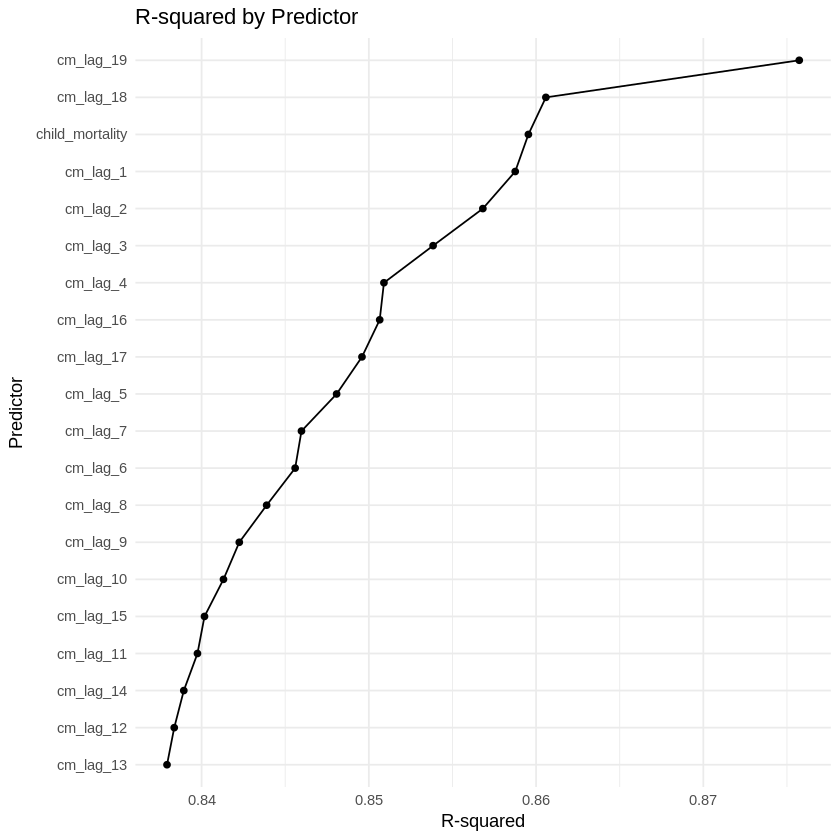

In [33]:
# Plotting R-squared for each predictor
ggplot(results_df, aes(x = reorder(predictor, r_squared), y = r_squared)) +
  geom_line(aes(group = 1)) +
  geom_point() +
  coord_flip() +  # optional: makes it easier to read
  labs(
    title = "R-squared by Predictor",
    x = "Predictor",
    y = "R-squared"
  ) +
  theme_minimal()


In [34]:
dim(train_lags)[1] - sum(is.na(train_lags$cm_lag_19))
dim(train_lags)[1] - sum(is.na(train_lags$cm_lag_18))
dim(train_lags)[1] - sum(is.na(train_lags$cm_lag_17))
dim(train_lags)[1] - sum(is.na(train_lags$cm_lag_16))

[1] 6

[1] 34

[1] 86

[1] 181

Not enough rows to take a couple of these higher lag variables seriously. `child_mortality` without lag performs well enough.

In [35]:
target_col <- "life_expectancy"
predictor_cols <- setdiff(names(train_lags), target_col)

model_stats <- lapply(predictor_cols, function(col) {
  formula <- as.formula(paste(target_col, "~", col))
  model <- tryCatch(lm(formula, data = train_lags), error = function(e) return(NULL))

  if (is.null(model)) return(NULL)

  summary_model <- summary(model)
  coef_table <- summary_model$coefficients

  # Ensure there is a slope coefficient (i.e., at least 2 rows: intercept + slope)
  if (nrow(coef_table) < 2) return(NULL)

  slope <- coef_table[2, 1]
  p_value <- coef_table[2, 4]

  # Safely extract CI
  conf <- tryCatch(confint(model)[2, ], error = function(e) return(c(NA, NA)))

  data.frame(
    predictor = col,
    slope = slope,
    lower_ci = conf[1],
    upper_ci = conf[2],
    r_squared = summary_model$r.squared,
    p_value = format(p_value, scientific=TRUE),
    significant = p_value < 0.05
  )
})

# Filter out NULLs (from dropped or broken models)
results_df <- do.call(rbind, Filter(Negate(is.null), model_stats))


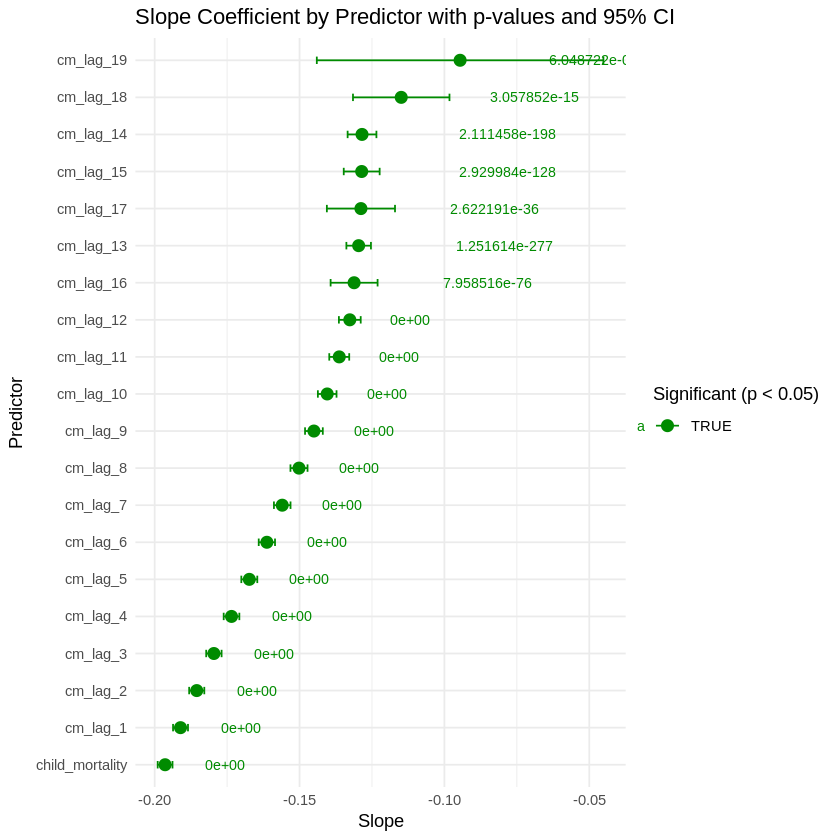

In [36]:
# Let's visualise these slope coefs, p-values and CIs
ggplot(results_df, aes(x = reorder(predictor, slope), y = slope, color = significant)) +
  geom_point(size = 3) +
  geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2) +
  geom_text(aes(label = sprintf(p_value)), hjust = -1, size = 3) +
  coord_flip() +
  scale_color_manual(values = c("TRUE" = "green4", "FALSE" = "gray60")) +
  labs(
    title = "Slope Coefficient by Predictor with p-values and 95% CI",
    x = "Predictor",
    y = "Slope",
    color = "Significant (p < 0.05)"
  ) +
  theme_minimal()


Interestingly the biggest difference the lag variables have here are seen in the slopes and confidence intervals. Huge difference mathematically speaking in some of the p-values but practically negligible. There's some but not a huge difference in the R-squared scores.

### Trying a subset of the more promising indicators

In [37]:
lm.subset <- lm(life_expectancy ~ child_mortality + global_development_resilience_index + health_development_ratio, data = train_sub)
summary(lm.subset)


Call:
lm(formula = life_expectancy ~ child_mortality + global_development_resilience_index + 
    health_development_ratio, data = train_sub)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.1670  -1.2566   0.3679   1.7279  19.3156 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         70.742701   0.302418  233.92   <2e-16 ***
child_mortality                     -0.147979   0.001931  -76.61   <2e-16 ***
global_development_resilience_index  0.090560   0.006677   13.56   <2e-16 ***
health_development_ratio             0.196358   0.011608   16.92   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.802 on 3706 degrees of freedom
Multiple R-squared:  0.9005,	Adjusted R-squared:  0.9005 
F-statistic: 1.118e+04 on 3 and 3706 DF,  p-value: < 2.2e-16


Looks a little too good to be true, let's check for multicollinearity.

In [38]:
cor(train_sub[, c("child_mortality",
                          "global_development_resilience_index",
                          "health_development_ratio")],
    use = "complete.obs")

,child_mortality,global_development_resilience_index,health_development_ratio
child_mortality,1.0000000,-0.8157442,-0.5969565
global_development_resilience_index,-0.8157442,1.0000000,0.8096050
health_development_ratio,-0.5969565,0.8096050,1.0000000


These are pretty strongly correlated, especially between `global_development_resilience_index` and the other two predictors. Multicollinearity could be a major issue here.

In [39]:
install.packages("car")  # Takes a few minutes, make sure to only run once
library(car)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:purrr’:

    some


The following object is masked from ‘package:dplyr’:

    recode




In [40]:
model <- lm(life_expectancy ~ child_mortality +
                                global_development_resilience_index +
                                health_development_ratio,
            data = train_sub)

vif(model)

child_mortality global_development_resilience_index 
                           3.097244                            5.786038 
           health_development_ratio 
                           3.007545

The `global_development_resilience_index` VIF value is of some concern. If I want to revisit this particular subset then it might be worth trying PCA or Ridge Regression. Until then I'll try a couple of different approaches.

### Polynomial fits

In [41]:
poly.fit1 <- lm(life_expectancy ~ poly(child_mortality, 10), data=train_sub)
summary(poly.fit1)


Call:
lm(formula = life_expectancy ~ poly(child_mortality, 10), data = train_sub)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.2102  -1.3155   0.4486   1.7926  12.0026 

Coefficients:
                             Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                   69.2312     0.0457 1514.921  < 2e-16 ***
poly(child_mortality, 10)1  -501.3683     2.7835 -180.118  < 2e-16 ***
poly(child_mortality, 10)2    93.5958     2.7835   33.625  < 2e-16 ***
poly(child_mortality, 10)3   -25.2480     2.7835   -9.070  < 2e-16 ***
poly(child_mortality, 10)4    18.9261     2.7835    6.799 1.22e-11 ***
poly(child_mortality, 10)5   -30.7309     2.7835  -11.040  < 2e-16 ***
poly(child_mortality, 10)6    21.4129     2.7835    7.693 1.84e-14 ***
poly(child_mortality, 10)7   -27.8449     2.7835  -10.003  < 2e-16 ***
poly(child_mortality, 10)8    16.1425     2.7835    5.799 7.22e-09 ***
poly(child_mortality, 10)9   -12.6906     2.7835   -4.559 5.30e-06 ***
poly(child_mortal

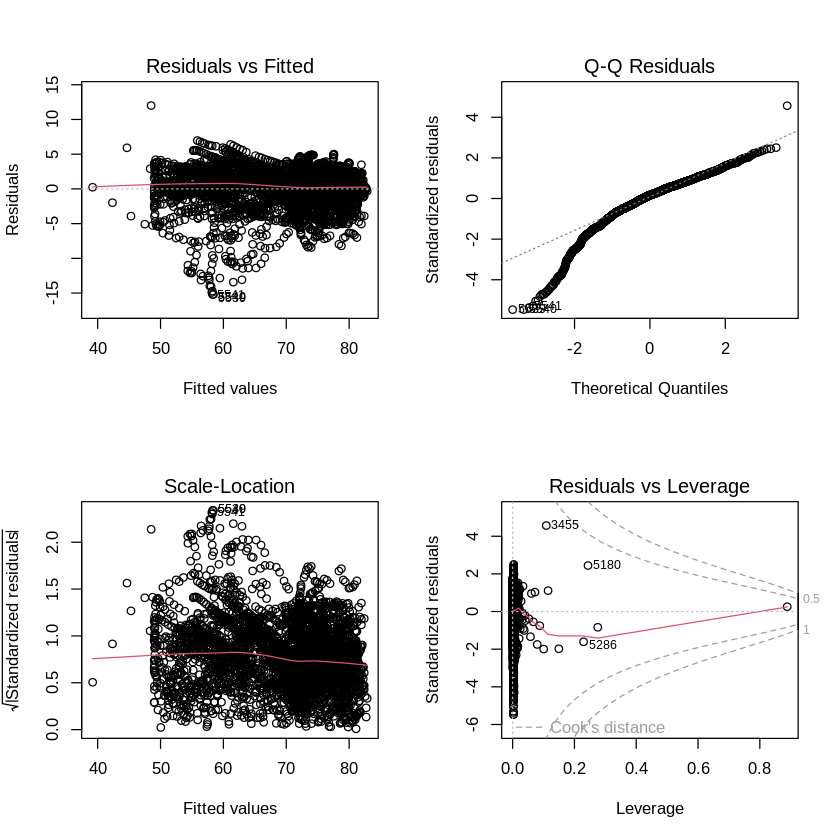

In [42]:
par(mfrow=c(2,2))
plot(poly.fit1)

In [43]:
poly.fit2 <- lm(life_expectancy ~ poly(global_development_resilience_index,  10), data=train_sub)
summary(poly.fit2)


Call:
lm(formula = life_expectancy ~ poly(global_development_resilience_index, 
    10), data = train_sub)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.4232  -2.0241   0.0477   1.8575  12.0351 

Coefficients:
                                                  Estimate Std. Error  t value
(Intercept)                                       69.23116    0.06487 1067.156
poly(global_development_resilience_index, 10)1   466.08248    3.95149  117.951
poly(global_development_resilience_index, 10)2  -126.82711    3.95149  -32.096
poly(global_development_resilience_index, 10)3     0.65641    3.95149    0.166
poly(global_development_resilience_index, 10)4    17.49683    3.95149    4.428
poly(global_development_resilience_index, 10)5   -25.51435    3.95149   -6.457
poly(global_development_resilience_index, 10)6    11.16471    3.95149    2.825
poly(global_development_resilience_index, 10)7    10.29046    3.95149    2.604
poly(global_development_resilience_index, 10)8   -11.49558    

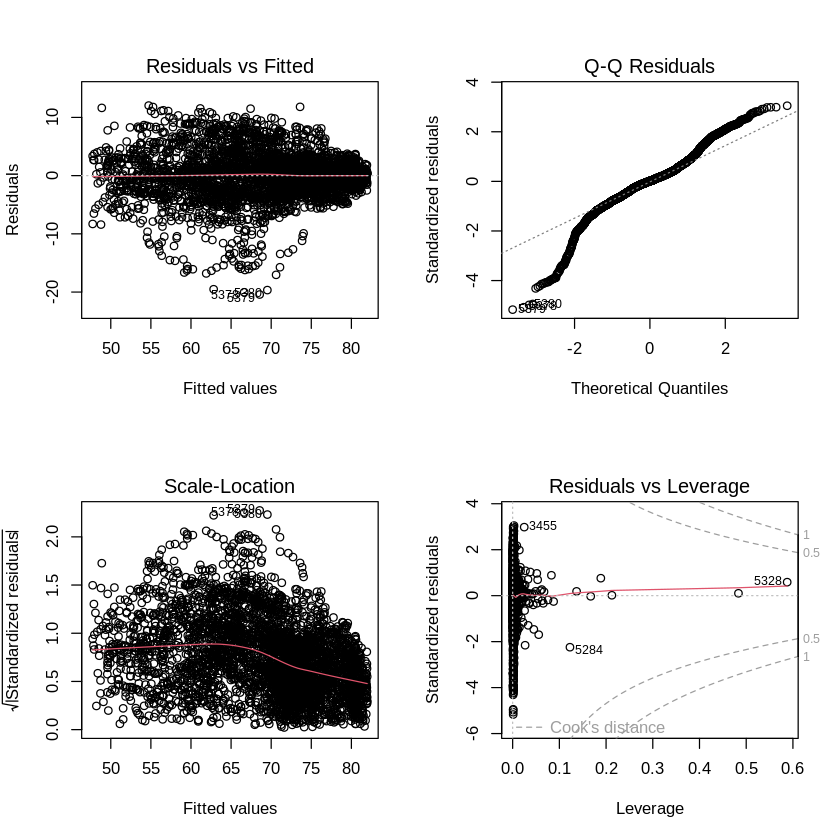

In [44]:
par(mfrow=c(2,2))
plot(poly.fit2)

In [45]:
poly.fit3 <- lm(life_expectancy ~ poly(health_development_ratio,  10), data=train_sub)
summary(poly.fit3)


Call:
lm(formula = life_expectancy ~ poly(health_development_ratio, 
    10), data = train_sub)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.3447  -1.2713   0.3072   1.6316   9.9136 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            69.23116    0.04051 1709.01   <2e-16 ***
poly(health_development_ratio, 10)1   381.68255    2.46742  154.69   <2e-16 ***
poly(health_development_ratio, 10)2  -217.22564    2.46742  -88.04   <2e-16 ***
poly(health_development_ratio, 10)3   165.86438    2.46742   67.22   <2e-16 ***
poly(health_development_ratio, 10)4  -130.39921    2.46742  -52.85   <2e-16 ***
poly(health_development_ratio, 10)5   112.07801    2.46742   45.42   <2e-16 ***
poly(health_development_ratio, 10)6   -92.57100    2.46742  -37.52   <2e-16 ***
poly(health_development_ratio, 10)7    73.71329    2.46742   29.88   <2e-16 ***
poly(health_development_ratio, 10)8   -53.99973    2.46742  -21.

In [46]:
poly.subset1 <- lm(life_expectancy ~ poly(health_development_ratio, 10) + poly(child_mortality, 10) + poly(global_development_resilience_index, 10), data = train_sub)
summary(poly.subset1)


Call:
lm(formula = life_expectancy ~ poly(health_development_ratio, 
    10) + poly(child_mortality, 10) + poly(global_development_resilience_index, 
    10), data = train_sub)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6805 -0.3055  0.0030  0.3079  7.2579 

Coefficients:
                                                  Estimate Std. Error  t value
(Intercept)                                      6.923e+01  9.096e-03 7611.021
poly(health_development_ratio, 10)1              4.576e+03  2.140e+01  213.897
poly(health_development_ratio, 10)2             -2.272e+03  9.924e+00 -228.887
poly(health_development_ratio, 10)3              1.356e+03  7.017e+00  193.207
poly(health_development_ratio, 10)4             -7.895e+02  4.701e+00 -167.931
poly(health_development_ratio, 10)5              4.930e+02  3.379e+00  145.915
poly(health_development_ratio, 10)6             -3.007e+02  2.551e+00 -117.903
poly(health_development_ratio, 10)7              1.940e+02  2.115e+00   91.735
po

Between the extroadinarily low RSE, high F-statistic and R squared scores - the polynomial model clearly overfits the data.

Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”
Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”


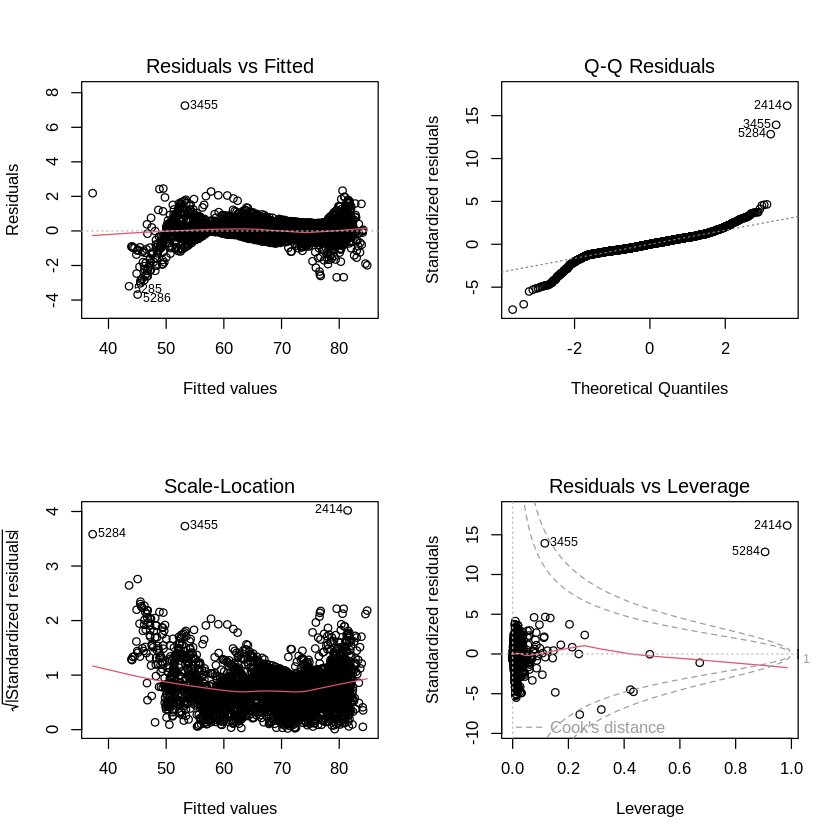

In [47]:
par(mfrow=c(2,2))
plot(poly.subset1)

In [48]:
summary(train_sub)

 life_expectancy child_mortality  global_development_resilience_index
 Min.   :39.44   Min.   :  2.00   Min.   :-0.6776                    
 1st Qu.:63.37   1st Qu.: 10.10   1st Qu.:28.0841                    
 Median :71.29   Median : 25.30   Median :39.8878                    
 Mean   :69.23   Mean   : 42.59   Mean   :40.6193                    
 3rd Qu.:75.46   3rd Qu.: 66.28   3rd Qu.:51.2959                    
 Max.   :85.42   Max.   :224.90   Max.   :95.0694                    
 health_development_ratio
 Min.   : 0.1754         
 1st Qu.: 0.9527         
 Median : 2.8387         
 Mean   : 5.6627         
 3rd Qu.: 7.4172         
 Max.   :41.2805         

### Looking for subsets from all numerical columns

In [49]:
install.packages("glmnet") # Takes a minute or two

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’




In [50]:
install.packages("leaps")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [51]:
install.packages("pls")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [52]:
library(glmnet)
library(leaps)
library(pls)

Loading required package: Matrix

Loaded glmnet 4.1-9


Attaching package: ‘pls’


The following object is masked from ‘package:stats’:

    loadings




If we wanted to find the best subset using a large amount of predictors then due to computation needs we would have to use forward or backward subset selection (once a predictor is in/out of the model it stays in/out). I don't think that'll be a great approach as it won't be very interpretable and there's too much overlap between predictors. Instead I'll perform the default (exchaustive) method which involves using all combinations of predictors but I'll also limit it to 10 to keep things simple.

In [53]:
regfit.full <- regsubsets(life_expectancy ~., train_num,
really.big=TRUE,
nvmax=10)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“8  linear dependencies found”


Reordering variables and trying again:


In [54]:
summary(regfit.full)

Subset selection object
Call: regsubsets.formula(life_expectancy ~ ., train_num, really.big = TRUE, 
    nvmax = 10)
39 Variables  (and intercept)
                                    Forced in Forced out
year                                    FALSE      FALSE
gdp_usd                                 FALSE      FALSE
population                              FALSE      FALSE
gdp_per_capita                          FALSE      FALSE
inflation_rate                          FALSE      FALSE
unemployment_rate                       FALSE      FALSE
fdi_pct_gdp                             FALSE      FALSE
co2_emissions_kt                        FALSE      FALSE
energy_use_per_capita                   FALSE      FALSE
renewable_energy_pct                    FALSE      FALSE
forest_area_pct                         FALSE      FALSE
electricity_access_pct                  FALSE      FALSE
child_mortality                         FALSE      FALSE
school_enrollment_secondary             FALSE      FALS

Interesting to see `global_development_resilience_index` disappear after the first model. `global_resilience_score` is in 8/10 of the models.

Let's see these subsets in an easier to visualise way.

In [55]:
library(tidyr)


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


The following object is masked from ‘numerical_data’:

    population


The following object is masked from ‘Indicators’:

    population




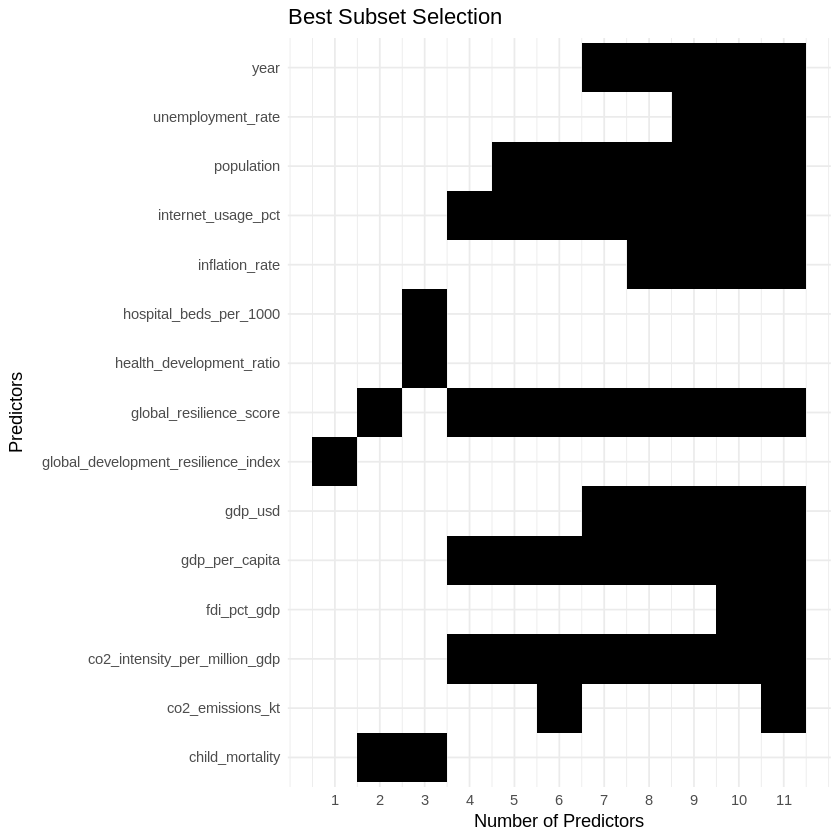

In [56]:
reg.summary <- summary(regfit.full)

# 1. Convert the matrix to a data frame
which_matrix <- as.data.frame(reg.summary$which)
which_matrix$model_size <- 1:nrow(which_matrix)

# 2. Convert to long format
which_long <- which_matrix %>%
  pivot_longer(-model_size, names_to = "predictor", values_to = "included") %>%
  filter(predictor != "(Intercept)" & included)

# 3. Create the plot
ggplot(which_long, aes(x = model_size, y = predictor)) +
  geom_tile(fill = "black") +
  theme_minimal() +
  labs(title = "Best Subset Selection",
       x = "Number of Predictors",
       y = "Predictors") +
  scale_x_continuous(breaks = 1:nrow(reg.summary$which))

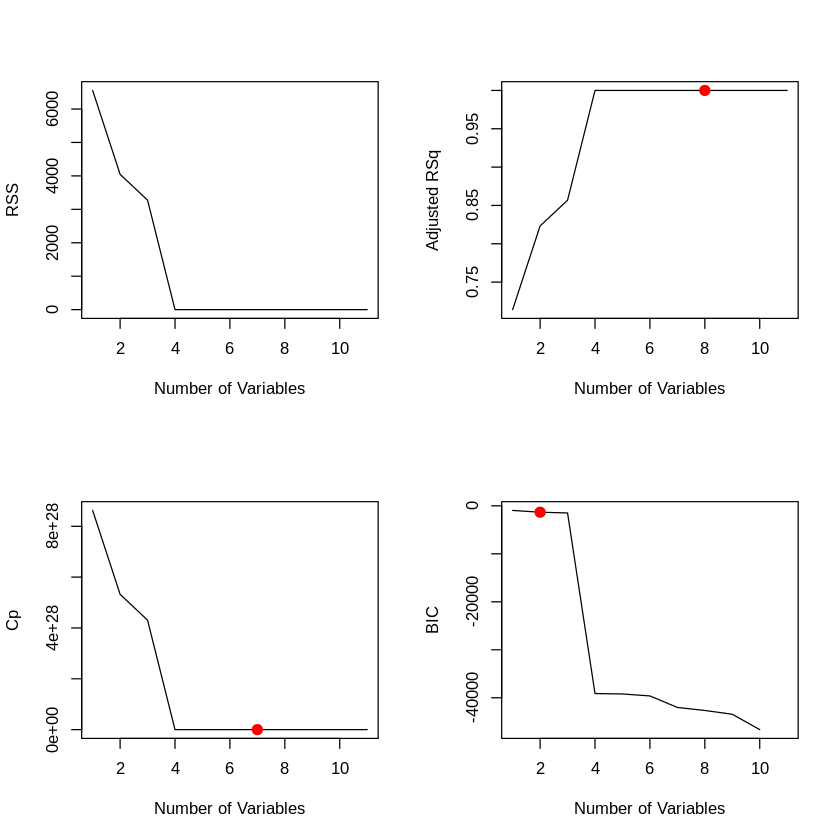

In [57]:
par(mfrow = c(2, 2))

plot(reg.summary$rss, xlab = "Number of Variables",
ylab = "RSS", type = "l")

plot(reg.summary$adjr2, xlab = "Number of Variables",
ylab = "Adjusted RSq", type = "l")

points(8, reg.summary$adjr2[8], col = "red", cex = 2,
pch = 20)

plot(reg.summary$cp , xlab = "Number of Variables",
ylab = "Cp", type = "l")

points (7, reg.summary$cp[7], col = "red", cex = 2,
pch = 20)

plot(reg.summary$bic , xlab = "Number of Variables",
ylab = "BIC", type = "l")

points(2, reg.summary$bic[2], col = "red", cex = 2,
pch = 20)

Models with 4 or greater predictors perform significantly differently to the 3 smaller models. The model with 4 predictors includes:
* `internet_usage_pct`
* `global_resilience_score`
* `gdp_per_capita`
* `co2_intensity_per_million_gdp`

These are the same predictors we took note of earlier when throwing all predictors into one big linear model.

In [58]:
train.sub <- lm(life_expectancy ~ internet_usage_pct + global_resilience_score + gdp_per_capita + co2_intensity_per_million_gdp, data=train_num)
summary(train.sub)

Warning message in summary.lm(train.sub):
“essentially perfect fit: summary may be unreliable”



Call:
lm(formula = life_expectancy ~ internet_usage_pct + global_resilience_score + 
    gdp_per_capita + co2_intensity_per_million_gdp, data = train_num)

Residuals:
       Min         1Q     Median         3Q        Max 
-5.913e-13 -2.041e-14 -9.500e-16  2.084e-14  2.566e-13 

Coefficients:
                                Estimate Std. Error    t value Pr(>|t|)    
(Intercept)                   -1.381e+02  9.352e-14 -1.477e+15   <2e-16 ***
internet_usage_pct            -6.375e-01  3.350e-16 -1.903e+15   <2e-16 ***
global_resilience_score        4.250e+02  1.899e-13  2.237e+15   <2e-16 ***
gdp_per_capita                -2.125e-03  9.859e-19 -2.155e+15   <2e-16 ***
co2_intensity_per_million_gdp  1.063e+02  4.807e-14  2.211e+15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.412e-14 on 771 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 2.949e+30 on 4 and 771 DF,  p-value: < 2.2e-16


Troubling results, let's examine.

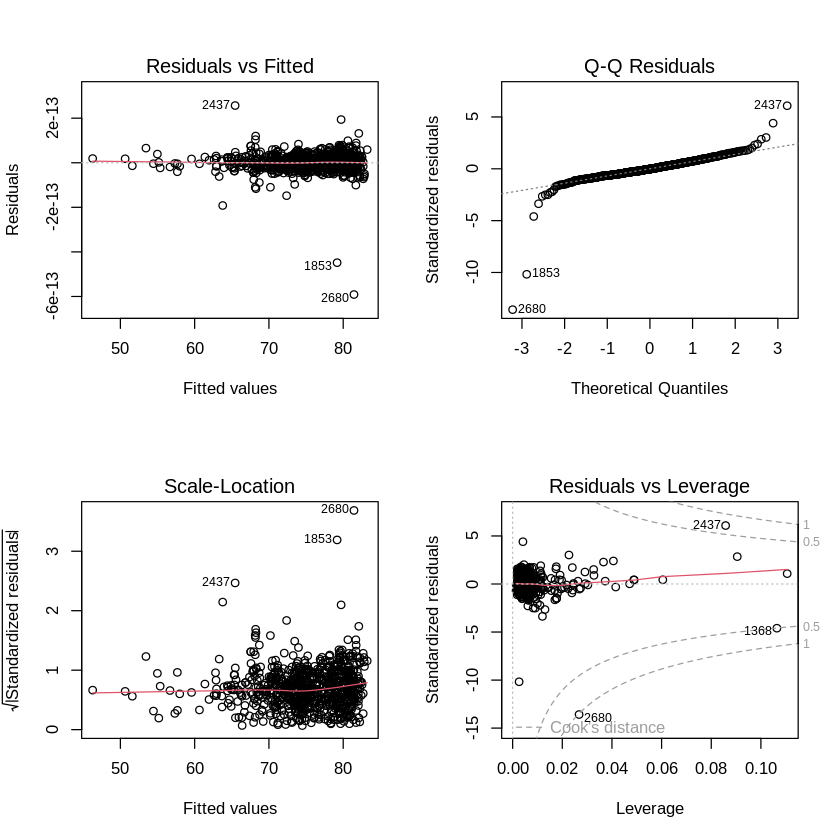

In [59]:
par(mfrow=c(2,2))
plot(train.sub)

In [60]:
car::vif(train.sub)

Warning message in summary.lm(object, ...):
“essentially perfect fit: summary may be unreliable”


internet_usage_pct       global_resilience_score 
                     37.19803                    1231.28950 
               gdp_per_capita co2_intensity_per_million_gdp 
                    169.69132                     512.53834

In [61]:
cor(train_num[, c("internet_usage_pct", "global_resilience_score", "gdp_per_capita", "co2_intensity_per_million_gdp", "life_expectancy")])


,internet_usage_pct,global_resilience_score,gdp_per_capita,co2_intensity_per_million_gdp,life_expectancy
internet_usage_pct,1.0000000,0.7816913,0.7592847,-0.5186634,0.7252824
global_resilience_score,0.7816913,1.0000000,0.7864473,-0.8974829,0.7116936
gdp_per_capita,0.7592847,0.7864473,1.0000000,-0.4509549,0.6662813
co2_intensity_per_million_gdp,-0.5186634,-0.8974829,-0.4509549,1.0000000,-0.5058882
life_expectancy,0.7252824,0.7116936,0.6662813,-0.5058882,1.0000000


In [62]:
anyDuplicated(train_num)

[1] 0

No duplicates but VIF and correlations confirm multicollinearity. If I want to go further here I'll need to use dimensionality reduction techniques like PCA or try to handle multicollinearity with a model like Ridge Regression or the Lasso.

In [63]:
install.packages("gam")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [64]:
library(gam)

Loading required package: splines

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loaded gam 1.22-5




### GLM (Generalised Linear Model)

We've seen from previous plots that even the best predictors aren't always perfectly linear. Time to try some more flexible models on the data.

In [65]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ foreach::accumulate() masks purrr::accumulate()
✖ tidyr::expand()       masks Matrix::expand()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
✖ tidyr::pack()         masks Matrix::pack()
✖ car::recode()         masks dplyr::recode()
✖ car::some()           masks purrr::some()
✖ tidyr::unpack()       masks Matrix::unpack()
✖ foreach::when()       masks purrr::when()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [66]:
library(boot)


Attaching package: ‘boot’


The following object is masked from ‘package:car’:

    logit




In [67]:
set.seed(42)

fit <- glm(life_expectancy ~ child_mortality, data = train_num)
err <- cv.glm(train_num, fit, K = 10)$delta[1]

fit1 <- glm(life_expectancy ~ poly(child_mortality, 4), data = train_num)
err1 <- cv.glm(train_num, fit1, K = 10)$delta[1]

Figuring out the number of bins to use for fit2 (step function) using cross-validation.

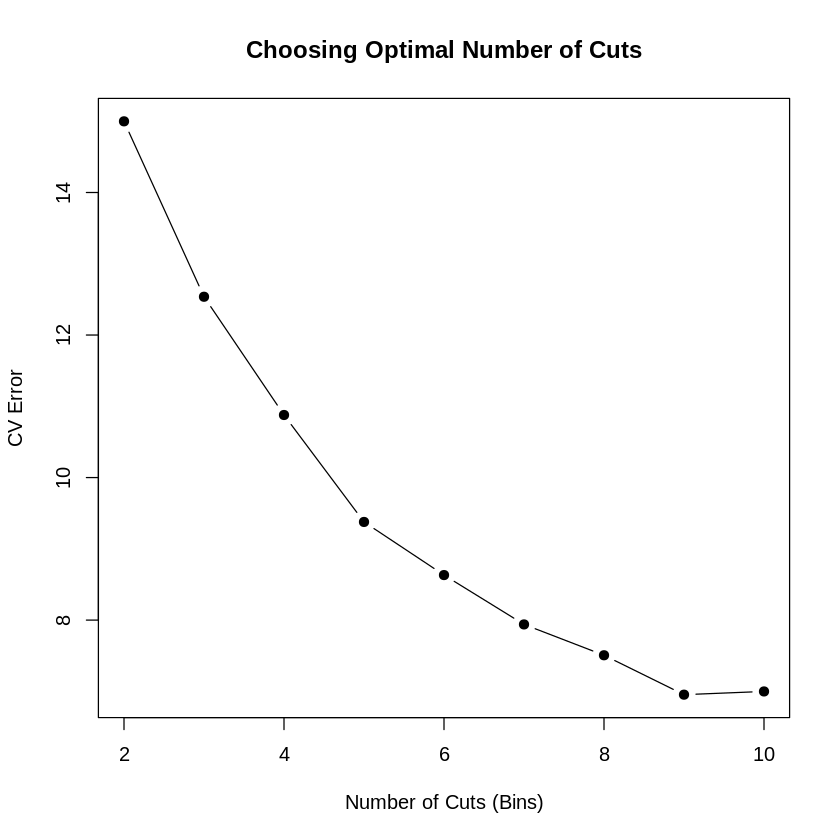

In [68]:
library(boot)

cv_errors <- sapply(2:10, function(k) {
  # Need to perform cross-validation manually to handle cutting within each fold
  # cv.glm is designed for fixed data
  n_folds <- 10
  folds <- sample(cut(seq(1, nrow(train_num)), breaks = n_folds, labels = FALSE))
  fold_errors <- numeric(n_folds)

  for(i in 1:n_folds) {
    train_indices <- which(folds != i)
    test_indices <- which(folds == i)

    train_data <- train_num[train_indices, ]
    test_data <- train_num[test_indices, ]

    # Define breaks based *only* on the training data for this fold
    breaks <- quantile(train_data$child_mortality, probs = seq(0, 1, length.out = k + 1), na.rm = TRUE)

    # Apply cuts to both training and test data using the same breaks
    train_data$cm_cats <- cut(train_data$child_mortality, breaks = breaks, include.lowest = TRUE)
    test_data$cm_cats <- cut(test_data$child_mortality, breaks = breaks, include.lowest = TRUE)

    # Train model on the training fold
    fit <- glm(life_expectancy ~ cm_cats, data = train_data)

    # Predict on the test fold and calculate error
    predictions <- predict(fit, newdata = test_data, type = "response")
    fold_errors[i] <- mean((test_data$life_expectancy - predictions)^2, na.rm = TRUE) # Use na.rm for robustness
  }
  mean(fold_errors, na.rm = TRUE) # Average errors across folds
})

plot(2:10, cv_errors, type = "b", pch = 19,
     xlab = "Number of Cuts (Bins)", ylab = "CV Error",
     main = "Choosing Optimal Number of Cuts")

6 cuts here will do

In [69]:
library(splines) # Needed for bs and ns

# Recut cm_cats on the full train_num dataset using the chosen optimal number of breaks (6)
# Ensure the breaks are calculated on the full train_num dataset as well for the final model
optimal_breaks <- quantile(train_num$child_mortality, probs = seq(0, 1, length.out = 6 + 1), na.rm = TRUE)
train_num$cm_cats <- cut(train_num$child_mortality, breaks = optimal_breaks, include.lowest = TRUE)

In [70]:
fit2 <- glm(life_expectancy ~ cm_cats, data = train_num)
err2 <- cv.glm(train_num, fit2, K = 10)$delta[1]

fit3 <- glm(life_expectancy ~ bs(child_mortality, df = 4), data = train_num)
err3 <- cv.glm(train_num, fit3, K = 10)$delta[1]

Warning message in bs(child_mortality, degree = 3L, knots = 8.3, Boundary.knots = c(2.4, :
“some 'x' values beyond boundary knots may cause ill-conditioned bases”
Warning message in bs(child_mortality, degree = 3L, knots = 8.3, Boundary.knots = c(2.4, :
“some 'x' values beyond boundary knots may cause ill-conditioned bases”


In [71]:
fit4 <- glm(life_expectancy ~ ns(child_mortality, 4), data = train_num)
err4 <- cv.glm(train_num, fit4, K = 10)$delta[1]

fit5 <- gam(life_expectancy ~ s(child_mortality, df = 4), data = train_num)
err5 <- mean(replicate(10, {
  b <- cut(sample(seq_along(train_num$child_mortality)), 10)
  pred <- numeric()
  for (i in 1:10){
    train <- b %in% levels(b)[-i]
    f <- gam(life_expectancy ~ s(child_mortality, df = 4), data = train_num[train, ])
    pred[!train] <- predict(f, train_num[!train, ])
  }
  mean((train_num$life_expectancy - pred)^2)
}))

c(err, err1, err2, err3, err4, err5)

[1]  8.587011 17.378573  8.980620  7.729187  6.159220  6.902586

`err4` which corresponds to `fit4` (natural spline with 4 df) is the lowest. Let's visualise.

In [72]:
anova(fit, fit1, fit2, fit3, fit4, fit5)

,Resid. Df,Resid. Dev,Df,Deviance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,774.0000,6629.972,NA,NA,NA,NA
2,771.0000,5309.977,3.000000e+00,1319.9955,49.42576,3.21035e-29
3,770.0000,6854.702,1.000000e+00,-1544.7250,NA,NA
4,771.0000,4901.443,-1.000000e+00,1953.2586,NA,NA
5,771.0000,4663.601,0.000000e+00,237.8421,NA,NA
6,770.9999,5245.105,9.984892e-05,-581.5038,NA,NA


Doesn't seem like ANOVA is too useful for comparing these models. Negative Df and NA for F and P values are because the models aren't nested. Model 2 (polynomial) looks significant however.

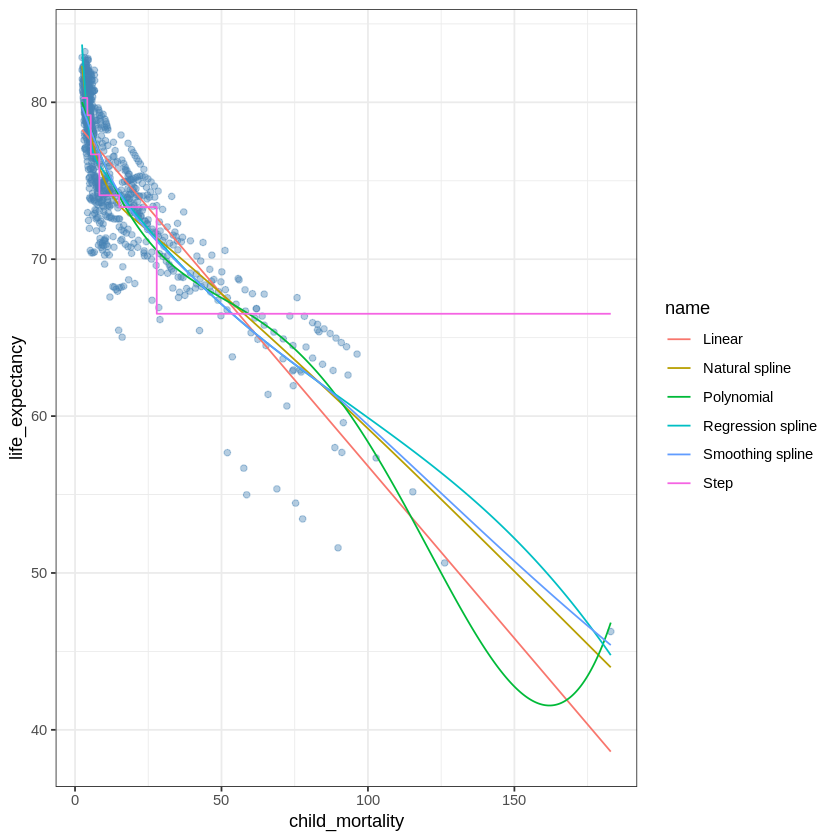

In [73]:
# Recalculate optimal_breaks based on the training data (already done, just re-confirming)
# optimal_breaks <- quantile(train_num$child_mortality, probs = seq(0, 1, length.out = 6 + 1), na.rm = TRUE)

# Create the sequence of child_mortality values for prediction
x <- seq(min(train_num$child_mortality), max(train_num$child_mortality), length.out = 3964)

# Create a data frame for prediction, ensuring cm_cats uses the *same* optimal_breaks
# Also ensure the levels match those in train_num$cm_cats
predict_data <- data.frame(child_mortality = x)
predict_data$cm_cats <- cut(predict_data$child_mortality, breaks = optimal_breaks, include.lowest = TRUE)

# Ensure the levels in predict_data$cm_cats are the same as in train_num$cm_cats
# This step is crucial to avoid the "new levels" error
levels(predict_data$cm_cats) <- levels(train_num$cm_cats)


pred <- data.frame(
  x = x,
  "Linear" = predict(fit, data.frame(child_mortality = x)),
  "Polynomial" = predict(fit1, data.frame(child_mortality = x)),
  # Use the 'predict_data' dataframe containing the correctly factored cm_cats
  "Step" = predict(fit2, newdata = predict_data),
  "Regression spline" = predict(fit3, data.frame(child_mortality = x)),
  "Natural spline" = predict(fit4, data.frame(child_mortality = x)),
  "Smoothing spline" = predict(fit5, data.frame(child_mortality = x)),
  check.names = FALSE
)
pred <- pivot_longer(pred, -x)
ggplot(train_num, aes(child_mortality, life_expectancy)) +
  geom_point(color = alpha("steelblue", 0.4)) +
  geom_line(data = pred, aes(x, value, color = name)) +
  theme_bw()

Natural and regression splines are looking the best here.

### Tree based approaches

In [74]:
install.packages("tree")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [75]:
library(tree)

In [76]:
set.seed(42)
train_tree <- sample(c(TRUE, FALSE), nrow(numerical_data), replace = TRUE)
test_tree <- sample(c(TRUE, FALSE), nrow(numerical_data[!train_tree,]), replace = TRUE)
tr <- tree(life_expectancy ~ ., data = numerical_data[train_tree, ])
summary(tr)


Regression tree:
tree(formula = life_expectancy ~ ., data = numerical_data[train_tree, 
    ])
Variables actually used in tree construction:
[1] "global_resilience_score"  "health_development_ratio"
[3] "electricity_access_pct"   "hospital_beds_per_1000"  
Number of terminal nodes:  8 
Residual mean deviance:  3.68 = 1733 / 471 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-7.92000 -1.11700  0.04803  0.00000  1.14900  6.21100 

Centered around zero with similar absolute values between 1st/3rd quartiles and min/max. Promising.

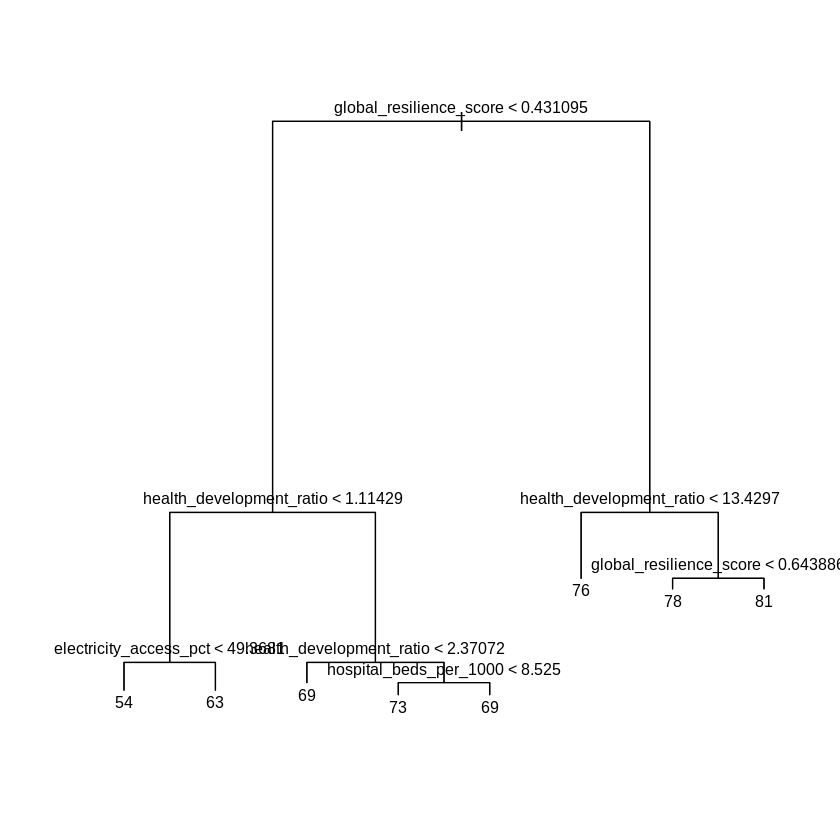

In [77]:
plot(tr)
text(tr, pretty = 0, digits = 2, cex = 0.8)

It seems like there's some quite significant gaps from 69-73 and 78-81 which are ranges that a lot of the data falls into. This could be problematic. As you can't interpolate here it might be worth trying random forests, but first I'll assess the model a little bit more.

In [78]:
le_mse <- function(model) {
  p <- predict(model, newdata = numerical_data[test_tree, ])
  mean((p - numerical_data[test_tree, "life_expectancy"])^2)
}
le_mse(tr)

[1] 4.810928

This shows the average prediction at being off by about 2.2 years. I'll see if pruning improves prediction at all.

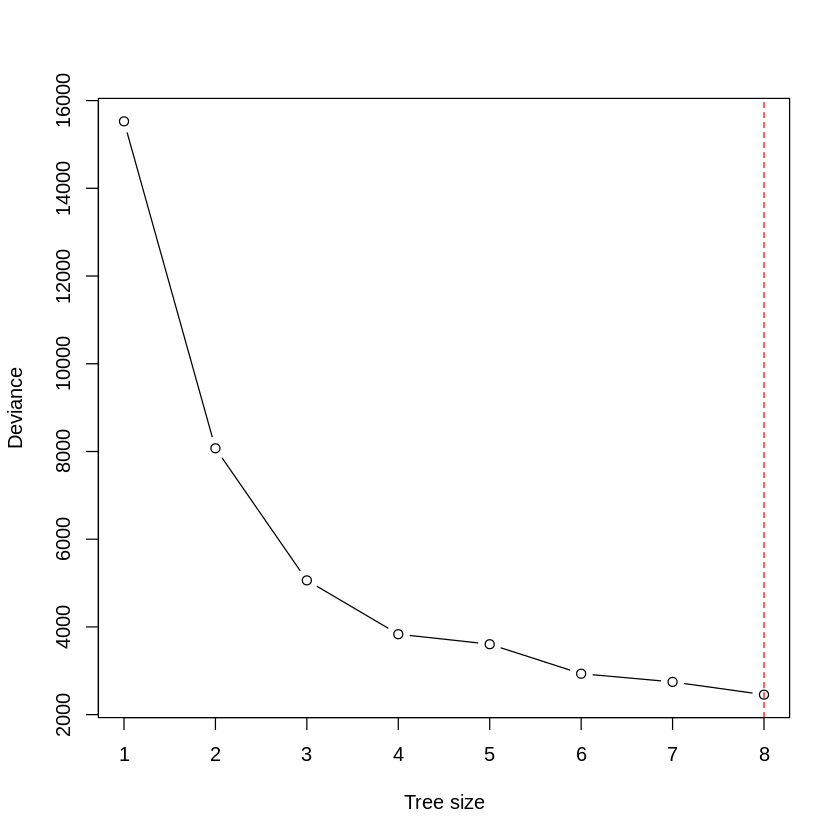

In [79]:
res <- cv.tree(tr)
plot(res$size, res$dev, type = "b", xlab = "Tree size", ylab = "Deviance")
min <- which.min(res$dev)
abline(v = res$size[min], lty = 2, col = "red")

6 Leaf nodes doesn't perform too differently from 7 but pruning isn't worth it. I'll try bagging and assess.

In [80]:
install.packages("randomForest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [81]:
library(randomForest)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




In [82]:
set.seed(42)

In [83]:
test_tree <- !train_tree

In [84]:
# Here we can use random Forest with mtry = 10 = p (the number of predictor
# variables) to perform bagging
bagged <- randomForest(life_expectancy ~ .,
  data = numerical_data[train_tree, ], mtry = 10,
  ntree = 200, importance = TRUE
)
le_mse(bagged)

[1] 1.695481

Huge improvement over the previous tree.

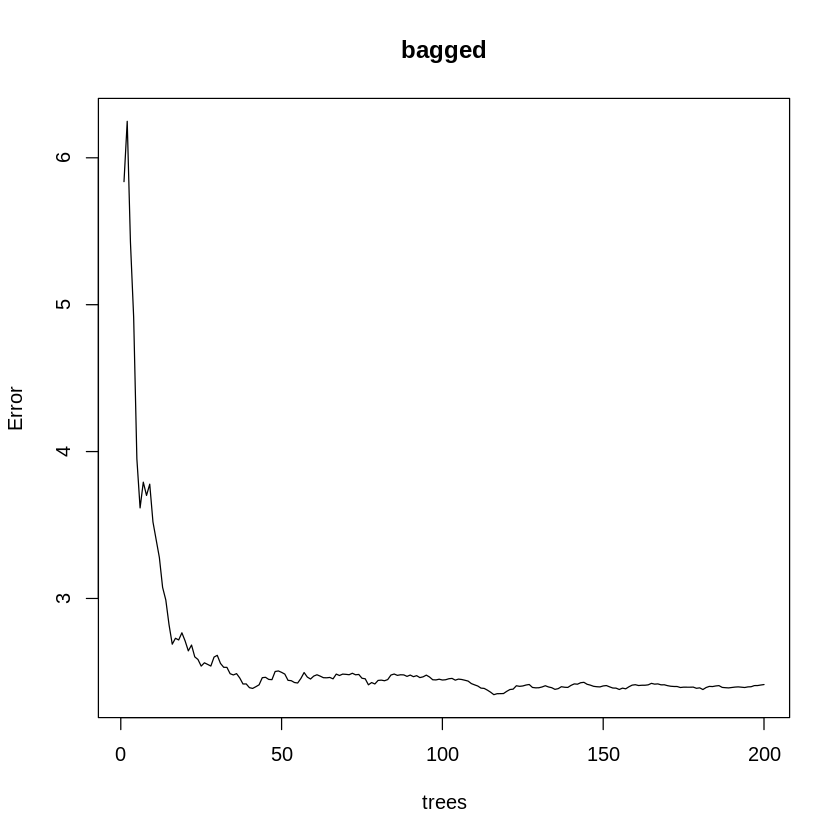

In [85]:
plot(bagged)

In [86]:
importance(bagged)

,%IncMSE,IncNodePurity
year,5.659526,43.79481
gdp_usd,4.655583,76.14386
population,4.763757,90.70383
gdp_per_capita,8.620551,1029.77980
inflation_rate,4.091217,60.45702
unemployment_rate,5.979945,84.60353
fdi_pct_gdp,3.559073,44.95462
co2_emissions_kt,4.699746,66.03985
energy_use_per_capita,4.645519,80.06707
renewable_energy_pct,5.606335,79.50786


Let's do the same but with `randomForest`

In [87]:
rf <- randomForest(life_expectancy ~ .,
  data = numerical_data[train_tree, ], mtry = 3,
  ntree = 500, importance = TRUE
)
le_mse(rf)

[1] 1.988473

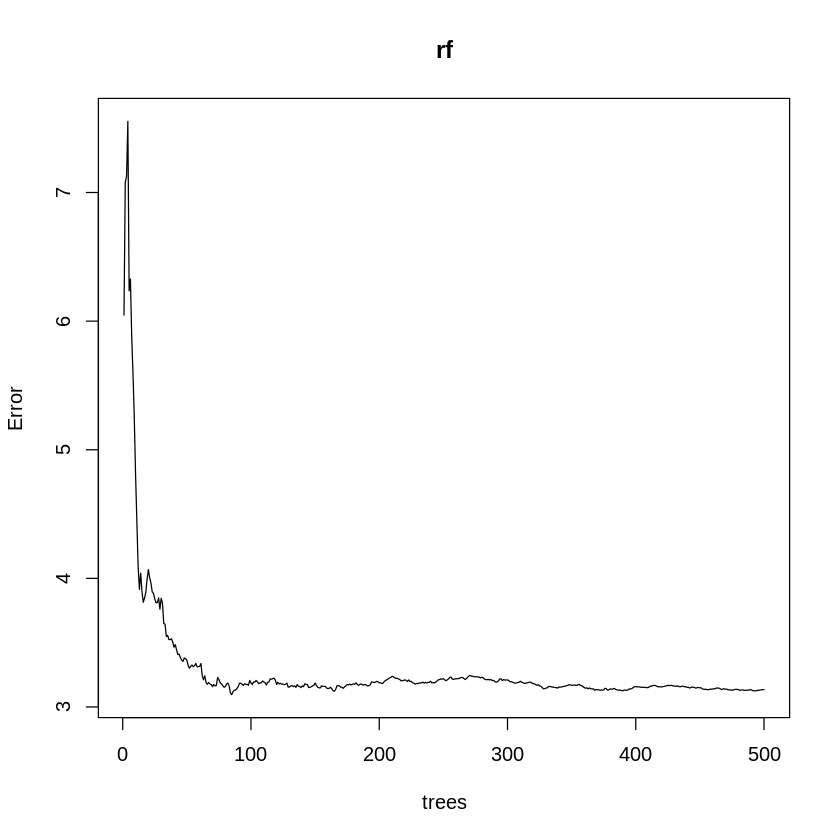

In [88]:
plot(rf)

In [89]:
importance(rf)

,%IncMSE,IncNodePurity
year,5.527468,57.69531
gdp_usd,9.194115,125.62337
population,8.841270,138.21698
gdp_per_capita,12.832237,1057.28939
inflation_rate,6.415670,149.30496
unemployment_rate,8.479534,121.87368
fdi_pct_gdp,4.801964,59.30285
co2_emissions_kt,8.706061,93.57971
energy_use_per_capita,9.321169,244.16721
renewable_energy_pct,8.748441,193.05669


Doesn't perform quite as well on the training data as bagging but still a very viable option. 500 Trees is also overkill in this situation but performance is still absolutely fine.

## 4. Trying our approaches on the test set

`test_num` `test_sub` and `test_tree`

Are our life expectancy values for `train_num` and `test_num` (which consist of numerical only data with no NA values) significantly different from one another?

In [90]:
t.test(test_num$life_expectancy, train_num$life_expectancy)


	Welch Two Sample t-test

data:  test_num$life_expectancy and train_num$life_expectancy
t = 1.0492, df = 299.35, p-value = 0.2949
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.397909  1.306787
sample estimates:
mean of x mean of y 
 75.47450  75.02007 


Nope, we can't reject the null hypothesis. Our sets are similar enough.

### On the simple linear regression using `child_mortality` as the predictor

Test values plotted against the linear regression line from the training set.

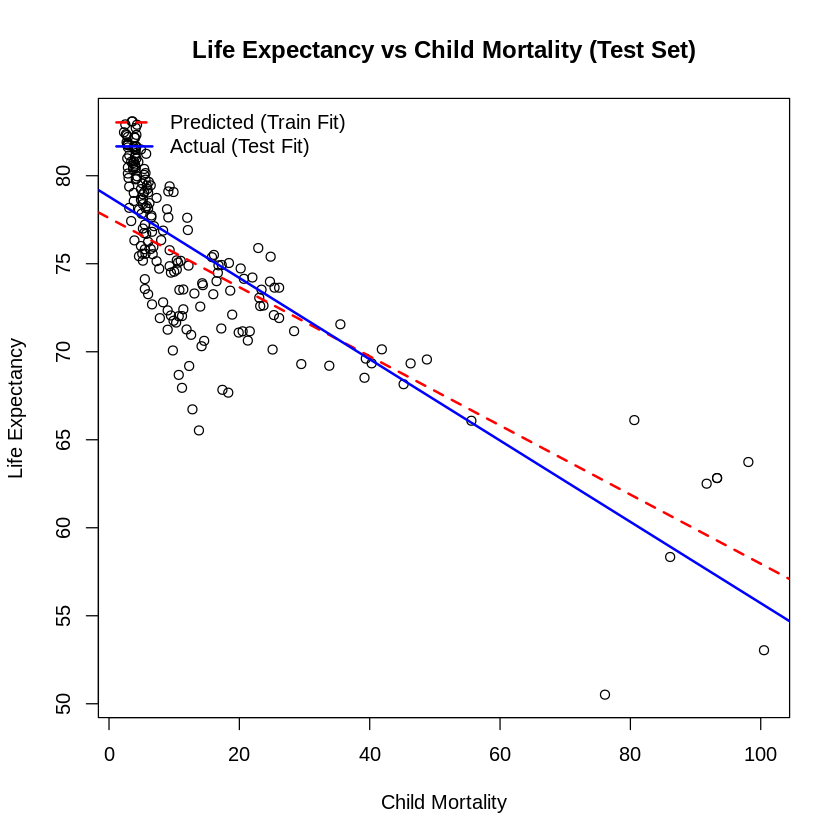

In [91]:
plot(test_num$child_mortality, test_num$life_expectancy,
     xlab = "Child Mortality", ylab = "Life Expectancy",
     main = "Life Expectancy vs Child Mortality (Test Set)")

abline(lm.fit, col = "red", lwd = 2, lty = 2)

test_fit <- lm(life_expectancy ~ child_mortality, data = test_num)
abline(test_fit, col = "blue", lwd = 2)

legend("topleft",
       legend = c("Predicted (Train Fit)", "Actual (Test Fit)"),
       col = c("red", "blue"),
       lty = c(2, 1),
       lwd = 2,
       box.lty = 0)

Fairly similar lines here. The actual line on the test set is steeper which tells us `child_mortality` has slightly more of an effect on `life_expectancy` in the test set than it does in the training set.

In [92]:
preds_num <- predict(lm.fit, test_num)

In [93]:
mae <- mean(abs(preds_num - test_num$life_expectancy))
mae

[1] 2.737069

Predictions are off by around 2.7 years on average

In [94]:
rmse <- sqrt(mean((preds_num - test_num$life_expectancy)^2))
rmse

[1] 3.378421

Larger errors are penalised more: typically ~3.4 years

In [95]:
sst <- sum((test_num$life_expectancy - mean(test_num$life_expectancy))^2)
sst

[1] 5594.545

Total variance in actual `life_expectancy` values

In [96]:
sse <- sum((test_num$life_expectancy - preds_num)^2)
sse

[1] 2214.263

Unexplained variation, in other words the difference between predictions and actuals.

In [97]:
r_squared <- 1 - sse / sst
r_squared

[1] 0.6042104

This tells us about 60% of the variation in `life_expectancy` is explained by `child_mortality`

Overall I'd say this model performs quite well for its simplicity.

In [98]:
dim(test_num)

[1] 194  40

### Let's try our Natural Spline fit on the test data

In [99]:
# Predict on test set using model from training set
preds <- predict(fit4, newdata = test_num)

In [100]:
actuals <- test_num$life_expectancy
rmse <- sqrt(mean((preds - actuals)^2))
print(rmse)

[1] 2.522375


This tells us that predictions using our natural spline fit on the test data are on average off by about 2.5 years.

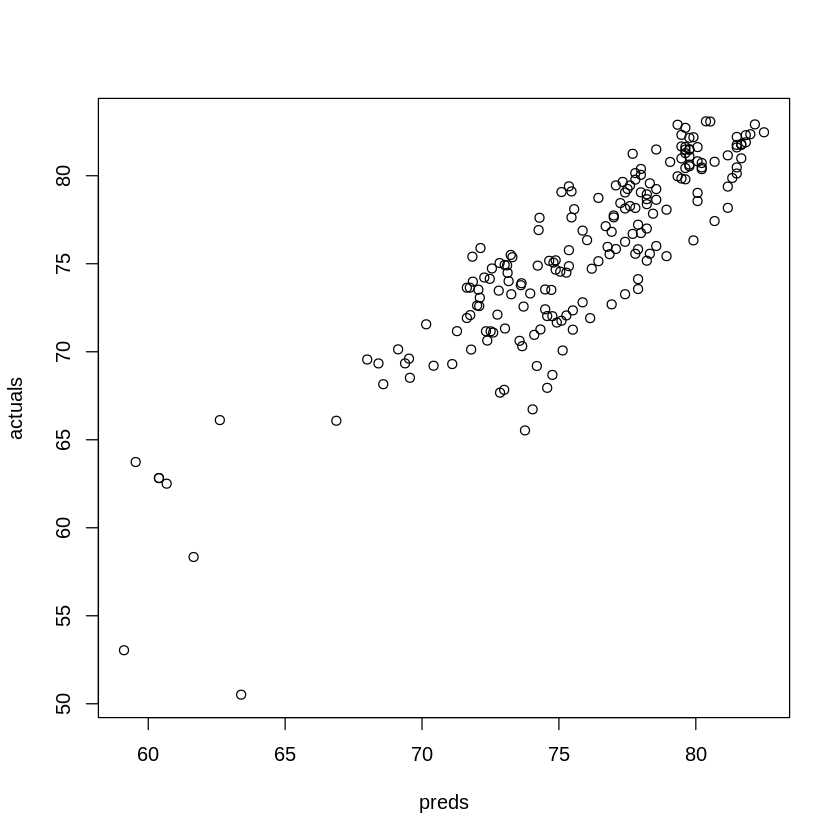

In [101]:
plot(preds, actuals)

Looks pretty good to me

### Time to try our Bagged trees

In [102]:
set.seed(42)

In [103]:
bagged_preds <- predict(bagged, newdata = numerical_data[test_tree, ])

In [104]:
rmse <- function(actual, predicted) {
  sqrt(mean((actual - predicted)^2))
}

rmse(numerical_data$life_expectancy[test_tree], bagged_preds)

[1] 1.302106

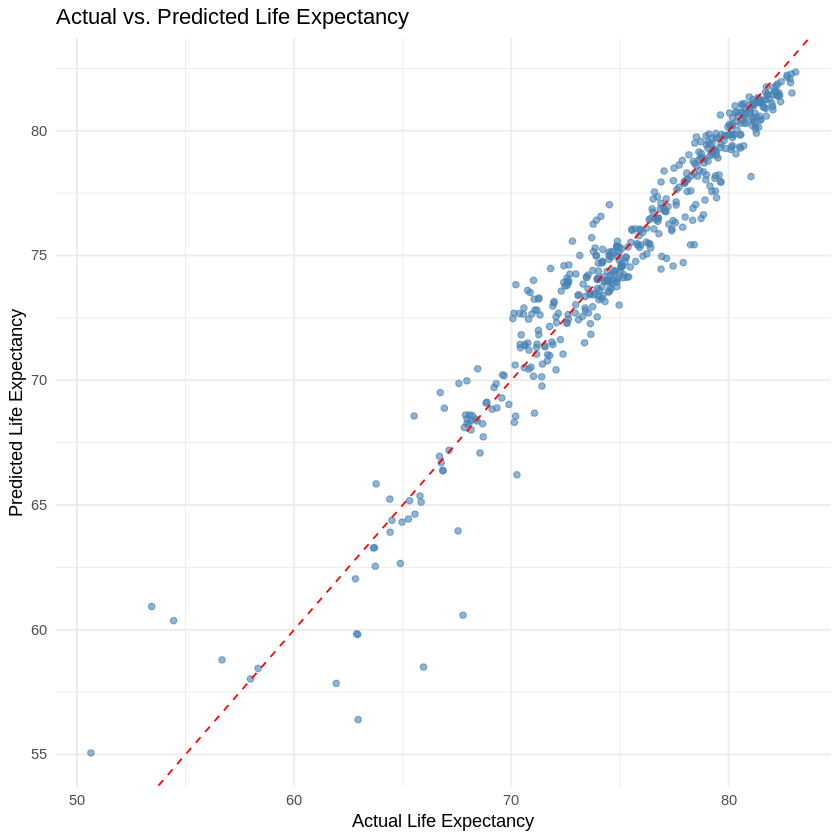

In [105]:
comparison_df <- data.frame(
  Actual = numerical_data[test_tree,]$life_expectancy,
  Predicted = bagged_preds
)

ggplot(comparison_df, aes(x = Actual, y = Predicted)) +
  geom_point(color = "steelblue", alpha = 0.6) +
  geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
  labs(title = "Actual vs. Predicted Life Expectancy",
       x = "Actual Life Expectancy",
       y = "Predicted Life Expectancy") +
  theme_minimal()


Wow.

## Conclusions

### ✅ Key findings

- `child_mortality` seems to be the strongest lone predictor of `life_expectancy` apart from columns suspected of multicollinearity.
- The best performing overall model for performance are bagged decision trees.
- Subsets do not seem particulary useful at face value.



### 🔍 Interpretation & real-world meaning

Life expectancy is likely more influenced by a country's cultural appreciation of health and approach to healthcare than economic, educational or environmental factors. That being said it seems wealthier countries tend to provide healthcare at more widespread and affordable rates which usually translates to higher life expectancy.

### ⚠️ Limitations

Not knowing the exact method used to construct certain columns creates issues as it's likely that several columns were constructed using `life_expectancy`. This disqualifies them as predictors. There are also significant amounts of NAs in the data which can hamper statistical significance in certain situations.

### 📈 Recommendations / Next steps

- Getting in contact with the author of the data may be useful to learn more about certain aspects of it.
- Exploring subsets further with PCA, Ridge Regression or the Lasso to tackle issues of multicollinearity.
